# Pulsars detection in sample of candidates

## Introduction
Pulsars are the class of neutron stars which have a strong electromagnetic field. The astrophysics simulations show that this field accelerates particles (mostly electrons and positrons) up to values close to the speed of light (https://www.youtube.com/watch?v=jwC6_oWwbSE). The part of the positrons cause strong gamma ray emission along the axis of magnetic poles. However, the star rotates around a diffetent fixed axis. Therefore, the beam of emission is pointing toward Earth only once each rotational period. 

<img src="scheme.jpg" width="40%" style="float: left; margin-right: 25px;"/>
<img src="pulsars.gif" width="55%" style="float: left;"/>

We analyse the HTRU2 dataset given by Dr Robert Lyon and available at https://archive.ics.uci.edu/ml/datasets/HTRU2. The dataset consists of the target class and first 4 statistical moments observed for both integrated pulse profile and signal-to-noise ratio of object dispersion measure (DM-SNR). Examples of profile and DM curve of pulsar candidate PSR J1706-6118 are presented in the following figure (http://www.scienceguyrob.com/wp-content/uploads/2016/12/WhyArePulsarsHardToFind_Lyon_2016.pdf).

<img src="IP_DM-SNR.jpg" width="80%" style="float: left; margin-right: 25px;"/>

## Data Overview

The dataset is downloaded and available in the folder `../../data/pulsar_stars/`. We import the CSV file by means of Pandas 

In [1]:
import pandas as pd

data = pd.read_csv('../../data/pulsar_stars/pulsar_stars.csv')
data.head(5)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Let us rename the columns to have more compact titles

In [2]:
columns = data.columns
column_names = list(['IP1', 'IP2', 'IP3', 'IP4', 'DM1', 'DM2', 'DM3', 'DM4'])
data = data.rename(columns = {
    columns[0]: column_names[0], columns[1]: column_names[1], columns[2]: column_names[2], columns[3]: column_names[3],
    columns[4]: column_names[4], columns[5]: column_names[5], columns[6]: column_names[6], columns[7]: column_names[7],
    columns[8]: 'target'
})
data.head(4)

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0


The general statistical description of the data is given by

In [3]:
data.describe()

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


It can be seen that standard deviations of features are in range from `1.064040` to `106.514540` and all attributes have non-zero means. We scale the dataset to have unit variances and zero means because it is more convinient to work with.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = data.copy()
scaled_data[column_names] = scaler.fit_transform(data[column_names].to_numpy())
scaled_data.describe()

,IP1,IP2,IP3,IP4,DM1,DM2,DM3,DM4,target
count,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,1.789800e+04,17898.000000
mean,-1.683261e-16,-3.437982e-16,5.716737e-17,1.270386e-17,-5.399140e-17,2.858368e-17,4.382831e-16,3.811158e-17,0.091574
std,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,0.288432
min,-4.103640e+00,-3.182449e+00,-2.212262e+00,-5.775478e-01,-4.207776e-01,-9.736032e-01,-2.539483e+00,-1.003034e+00,0.000000
25%,-3.956882e-01,-6.098955e-01,-4.236418e-01,-3.175961e-01,-3.627611e-01,-6.106403e-01,-5.597136e-01,-6.562405e-01,0.000000
50%,1.558601e-01,5.815398e-02,-2.392997e-01,-2.548046e-01,-3.329443e-01,-4.039644e-01,2.884145e-02,-2.046083e-01,0.000000
75%,6.239604e-01,6.537588e-01,-4.259430e-03,-1.365972e-01,-2.426074e-01,1.079397e-01,5.324947e-01,3.234543e-01,0.000000
max,3.178564e+00,7.632529e+00,7.134956e+00,1.075456e+01,7.151778e+00,4.330538e+00,5.822567e+00,1.019742e+01,1.000000


In order to see if there is dependence between features let us build the correlation matrix 

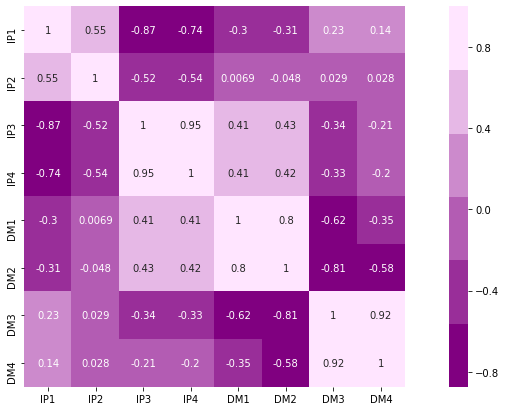

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

palette = sns.light_palette("purple", reverse = True)

corr = scaled_data.filter(regex = "[^target]").corr()
plt.figure(figsize = (16, 7))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = palette, square = True, annot = True)
plt.show()

There is a strong correlation between `IP3` - `IP4` and `DM3` - `DM4`. However, not every feature is important for our classification issue. This is clearly seen from the following pairwise relationships. The purple points represent pulsars. The distribution densities are fit by histograms and ploted along the main diagnoal for each of the features.

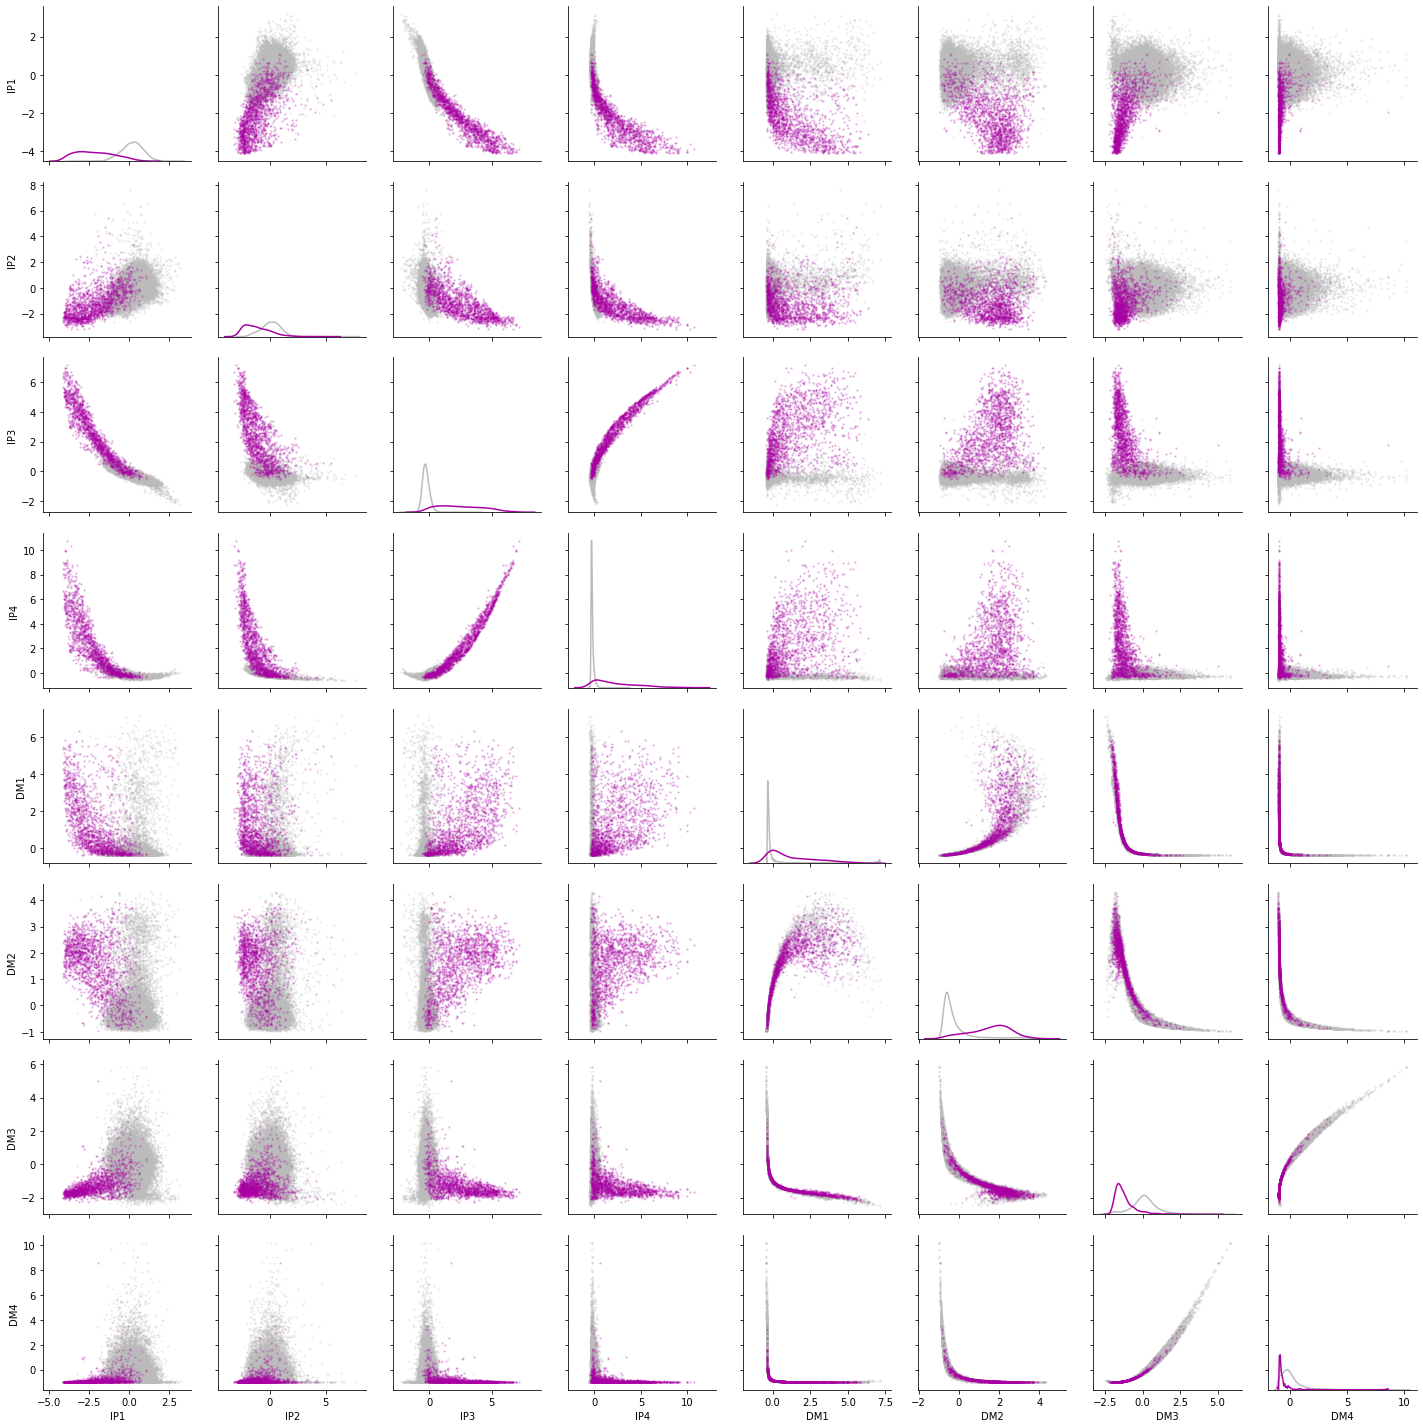

In [6]:
palette2 = sns.color_palette(["#bbbbbb", "#a800a2"])

pg = sns.PairGrid(scaled_data, palette = palette2, hue = "target", hue_order = [0, 1], vars = column_names)

pg.map_diag(sns.kdeplot),
pg.map_offdiag(plt.scatter, s = 2, alpha = 0.2)

It can be seen that some features allows one to split the data set linearly very well.

Another important point is that our data is imbalanced. We should take it into account for some classification algorithms.

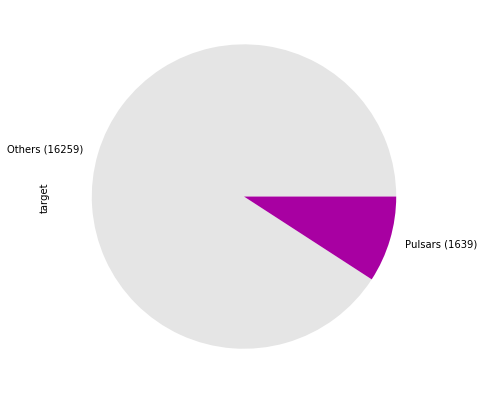

In [7]:
number_of_others, number_of_pulsars = scaled_data.target.value_counts()
scaled_data.target.value_counts().plot(kind = 'pie', labels = ['Others (' + str(number_of_others) + ')',
                                                               'Pulsars (' + str(number_of_pulsars) + ')'],
                                       figsize = (7, 7), colors = ['#e5e5e5', '#a800a2'])

## Classification Model

We split our data to train and test sets

In [8]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate, train_test_split

X = scaled_data.filter(regex = "[^target]").values
y = scaled_data.target.values

Let resample our training data to have equal amount of pulsars and the other stars. We use undersampling technique for the further research as it shows better training results.

In [9]:
# from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

# sampler = ADASYN()
# X_oversampled, y_oversampled = sampler.fit_sample(X, y)

sampler = RandomUnderSampler()
X_undersampled, y_undersampled = sampler.fit_sample(X, y)

print(X.shape)
# print(X_oversampled.shape)
print(X_undersampled.shape)

Using TensorFlow backend.


(17898, 8)
(3278, 8)


Implement classifier evaluation helper function using cross-validation and ROC analysis. We use Stratified K-Fold alghoritm in order to split our data for the training and validation

In [10]:
import numpy as np
from scipy import interp
from sklearn.metrics import roc_curve, auc, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import figure
from functools import reduce
from benedict import benedict


def average_report(reports):
    result = benedict()
    for path in set(benedict(reports[0]).keypaths()).difference(
            list(['Non-pulsars', 'Pulsars', 'macro avg', 'weighted avg'])):
        average = reduce((lambda acc, report: acc + benedict(report)[path]), reports, 0) / len(reports)
        result[path] = average
    return result


def evaluate_classifier(classifier, X_set, y_set):
    fig = plt.figure(figsize = (14, 4))
    target_names = ['Non-pulsars', 'Pulsars']

    cv = StratifiedKFold(n_splits = 5)
    tprs = []
    aucs = []
    reports = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_set, y_set):
        #         print('Fold ' + str(i))
        classifier.fit(X_set[train], y_set[train])
        y_pred = classifier.predict(X_set[test])
        # Compute reports
        report = classification_report(y_set[test], y_pred, target_names = target_names, output_dict = True)
        # Compute ROC curve and area the curve
        probas = classifier.predict_proba(X_set[test])
        fpr, tpr, thresholds = roc_curve(y_set[test], probas[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        report['auc'] = roc_auc
        reports.append(report)
        i += 1

    mean_tpr = np.mean(tprs, axis = 0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax1 = fig.add_subplot(121)
    plt.rcParams["figure.figsize"] = (5, 5)
    ax1.plot(mean_fpr, mean_tpr, color = '#a800a2',
             label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw = 2, alpha = 1)

    std_tpr = np.std(tprs, axis = 0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                     label = r'$\pm$ 1 std. dev.')
    ax1.set_aspect(1.0)
    plt.xlim([0, 0.25])
    plt.ylim([0.75, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of ' + classifier.__class__.__name__)
    plt.legend(loc = "lower right")

    ax2 = fig.add_subplot(122)
    font_size = 14
    bbox = [0, 0, 1, 1]
    ax2.axis('off')

    report = average_report(reports)

    def f(path):
        return "{0:.4f}".format(report[path])

    cell_text = [
        [f('Non-pulsars.precision'), f('Non-pulsars.recall'), f('Non-pulsars.f1-score')],
        [f('Pulsars.precision'), f('Pulsars.recall'), f('Pulsars.f1-score')],
        ['', '', ''],
        [f('macro avg.precision'), f('macro avg.recall'), f('macro avg.f1-score')],
        [f('weighted avg.precision'), f('weighted avg.recall'), f('weighted avg.f1-score')],
        ['', '', ''],
        ['', '', f('accuracy')]]

    rows_labels = ['Non-pulsars', 'Pulsars', '', 'macro avg', 'weighted avg', '', 'accuracy']
    column_labels = ['avg precision', 'avg recall', 'avg f1-measure']

    table = ax2.table(cellText = cell_text, rowLabels = rows_labels,
                      colLabels = column_labels, loc = 'center')
    table.scale(1, 2)
    table.auto_set_font_size(False)
    table.set_fontsize(font_size)
    return report

### C-Support Vector Classifier

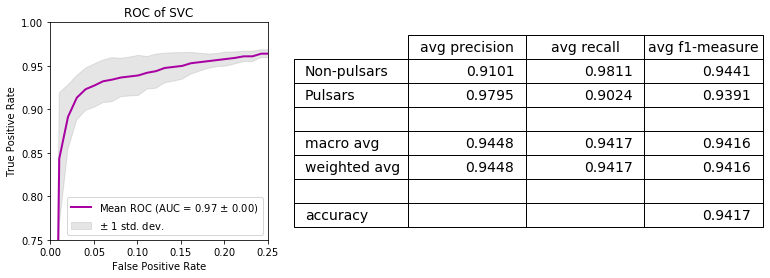

In [11]:
import matplotlib.pyplot as plt
from sklearn import svm

classifier = svm.SVC(kernel = 'linear', probability = True, random_state = 1)
avg_report_svc = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Logistic Regression Classifier

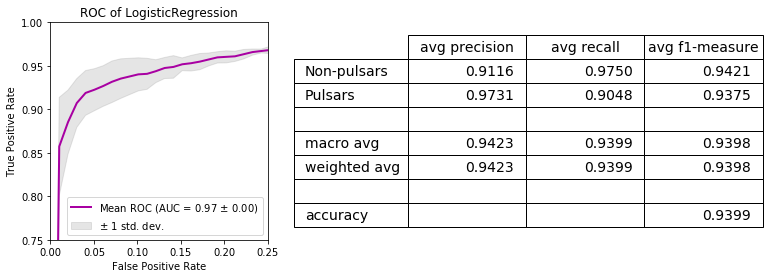

In [12]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver = 'lbfgs')
avg_report_lr = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### K-Neighbors Classifier

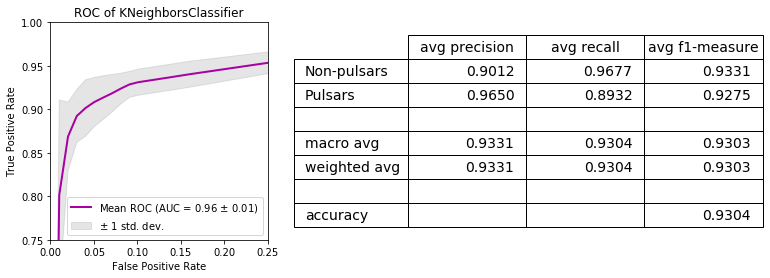

In [13]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 13)
avg_report_kn = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Decision Tree Classifier

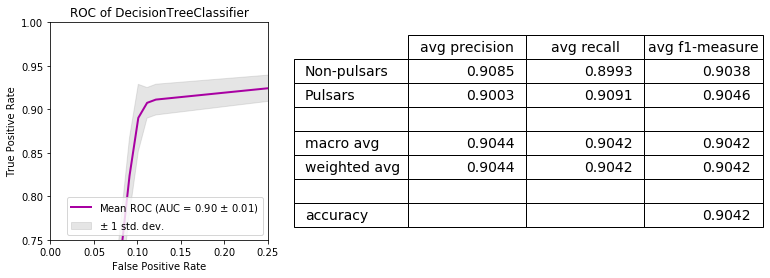

In [14]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
avg_report_dt = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Random Forest Classifier

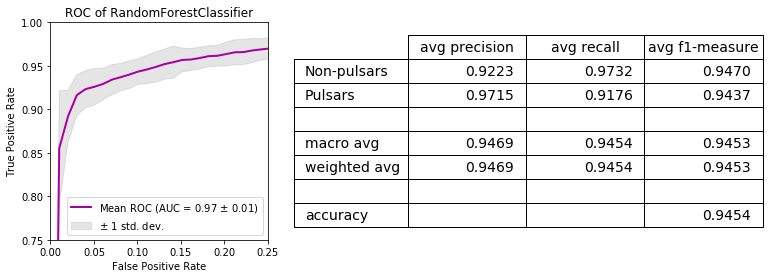

In [15]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 200, random_state = 3)
avg_report_rf = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Naive Bayes Classifier

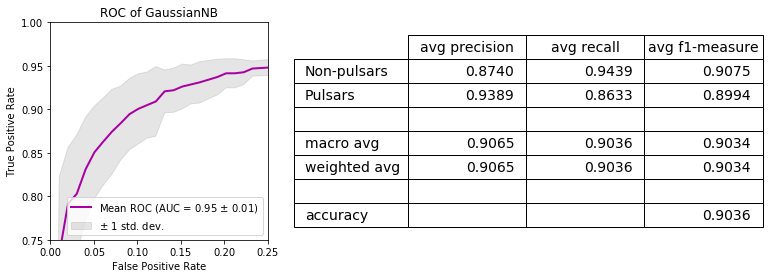

In [16]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
avg_report_nb = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Gradient Boosting Classifier

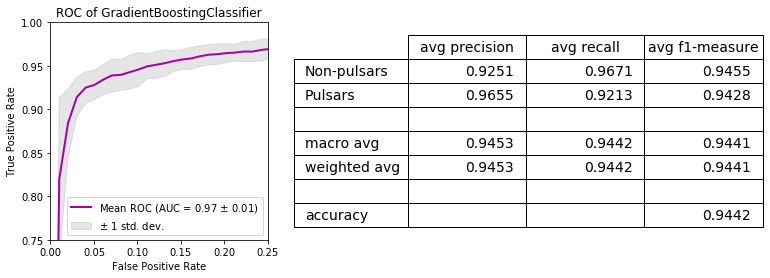

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(n_estimators = 150, learning_rate = 0.1, max_features = 2,
                                        max_depth = 2, random_state = 0)
avg_report_gb = evaluate_classifier(classifier, X_undersampled, y_undersampled)

### Neural Network Classifier

/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/zhuvikin/anaconda3/envs/AIU_ML/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum ite

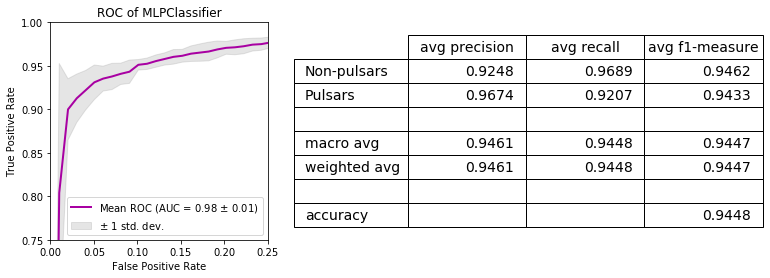

In [30]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(hidden_layer_sizes = (8, 4, 2), max_iter = 500, alpha = 0.00025,
                           solver = 'adam', verbose = 0, random_state = 21, tol = 0.000000001, activation = 'relu')
avg_report_mlp = evaluate_classifier(classifier, X_undersampled, y_undersampled)

## Comparative Analysis

Let us summarize the results given by the various alghoritms

In [70]:
from IPython.display import HTML, display
import tabulate

reports = [avg_report_svc, avg_report_lr, avg_report_kn, avg_report_dt,
           avg_report_rf, avg_report_nb, avg_report_gb, avg_report_mlp]

classifier_names = ['C-Support Vector', 'Logistic Regression', 'K-Neighbors', 'Decision Tree',
                    'Random Forest', 'Naive Bayes', 'Gradient Boosting', 'Neural Network']

measures_names = ['Accuracy', 'Precision', 'Recall', 'F1-measure', 'AUC']

accuracies = list(map(lambda report: "{0:.4f}".format(report['accuracy'] * 100) + ' %', reports))
precisions = list(map(lambda report: "{0:.4f}".format(report['Pulsars.precision'] * 100) + ' %', reports))
recalls = list(map(lambda report: "{0:.4f}".format(report['Pulsars.recall'] * 100) + ' %', reports))
f1Measures = list(map(lambda report: "{0:.4f}".format(report['Pulsars.f1-score'] * 100) + ' %', reports))
AUCs = list(map(lambda report: "{0:.4f}".format(report['auc']), reports))

c_results = pd.DataFrame([
    [measures_names[0]] + accuracies,
    [measures_names[1]] + precisions,
    [measures_names[2]] + recalls,
    [measures_names[3]] + f1Measures,
    [measures_names[4]] + AUCs
], columns = [''] + classifier_names)

c_results.style.applymap(lambda x: 'background-color : magenta; color: white'
if x == max(accuracies)
   or x == max(precisions)
   or x == max(recalls)
   or x == max(f1Measures)
   or x == max(AUCs) else '')

,,C-Support Vector,Logistic Regression,K-Neighbors,Decision Tree,Random Forest,Naive Bayes,Gradient Boosting,Neural Network
0,Accuracy,94.1742 %,93.9909 %,93.0447 %,90.4204 %,94.5399 %,90.3616 %,94.4176 %,94.4794 %
1,Precision,97.9461 %,97.3059 %,96.4952 %,90.0345 %,97.1538 %,93.8896 %,96.5494 %,96.7417 %
2,Recall,90.2391 %,90.4830 %,89.3231 %,90.9077 %,91.7642 %,86.3342 %,92.1299 %,92.0696 %
3,F1-measure,93.9114 %,93.7534 %,92.7518 %,90.4583 %,94.3728 %,89.9362 %,94.2765 %,94.3284 %
4,AUC,0.9757,0.9768,0.9667,0.9042,0.9767,0.9535,0.9778,0.9786


The greatest values of correspondent measures are highlighted. It can be seen that the best ML alghorithm for pulsars classification depends on what measure is going to be used

## Conclusion

Various ML algorithms for the task of pulsars detection are evaluated. The source is re-scaled and re-balanced to have zero mean, unit variance and the same amount of elements in both target classes. We evaluated C-Support Vector, Logistic Regression, K-Neighbors, Decision Tree, Random Forest, Naive Bayes, Gradient Boosting and Neural Network classifiers in order to determine the best one. The general discriminitive ability is given by the area under ROC curve. The alghoritm based on neural network shows the best result by AUC measure. However, it is more inportant to have higher recall, F1-measure. So, Random Forest and Gradient Boosting do the job better.